## **Milestone 2 -  Designing Hyperblock for Model Selection**

Based on the notebook of Xiaotian Han



Implement the an automated deep learning model for image classification using the Funtional API of AutoKeras. The step is listed as follows:

1. Load and prepare cifar10 dataset
2. Build a AutoKeras hyperblock for model selection
3. Build a AutoML pipeline
4. Retrain and explore the searched model

In [1]:
%%capture
#!pip install tensorflow==2.5.0
#!pip install autokeras==1.0.16

In [2]:
# import the python packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Layer, Dense, ReLU, Softmax, MaxPooling2D, Flatten, Conv2D

import autokeras as ak

from typing import Optional
from typing import Union

import tensorflow as tf
from kerastuner.engine import hyperparameters
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.python.util import nest

from autokeras import keras_layers
from autokeras.blocks import reduction
from autokeras.engine import block as block_module
from autokeras.utils import layer_utils
from autokeras.utils import utils

print( "tf.__version__:", tf.__version__ )
print( "ak.__version__:", ak.__version__ )

tf.__version__: 2.5.0
ak.__version__: 1.0.16


C:\Users\carlos\AppData\Local\Temp/ipykernel_596/523385367.py:20: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine import hyperparameters


## Load and prepare cifar10 dataset

#### load cifar10 data

In [3]:
# Load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

from sklearn.utils import resample
x_train, y_train = resample(x_train, y_train, n_samples=10000, replace=False, random_state=0)

print('Training image shape:', x_train.shape)
print('Training label shape:', y_train.shape)
print('Testing image shape:', x_test.shape)
print('Testing label shape:', y_test.shape)

Training image shape: (10000, 32, 32, 3)
Training label shape: (10000, 1)
Testing image shape: (10000, 32, 32, 3)
Testing label shape: (10000, 1)


#### Prepare data

In [4]:
# scale
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshape
x_train = x_train.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)
print('Training image shape:', x_train.shape)
print('Training label shape:', y_train.shape)
print('Testing image shape:', x_test.shape)
print('Testing label shape:', y_test.shape)

Training image shape: (10000, 32, 32, 3)
Training label shape: (10000, 1)
Testing image shape: (10000, 32, 32, 3)
Testing label shape: (10000, 1)


## Build a AutoKeras hyperblock for model selection

This is a joint of hyperparameter tuning and model selection task.


In [5]:
# Customize a DenseNetBlock which includes different types of DenseNet.
class DenseNetBlock(ak.Block):
  def build(self, hp, inputs):
    version = hp.Choice("version", ["DenseNet121", "DenseNet169", "DenseNet201"])
    # Select the according model based on the text of verison
    if version == "DenseNet121":
          dense_net_func = applications.DenseNet121
    elif version == "DenseNet169":
          dense_net_func = applications.DenseNet169
    elif version == "DenseNet201":
          dense_net_func = applications.DenseNet201
    else:
          print("Error: Wrong version")
    return dense_net_func(include_top=False, weights=None)(inputs)

# Model selection block
class SelectionBlock(ak.Block):
  def build(self, hp, inputs):
    # Select the according model based on the text of model_type
    # Any hyperparameter defined under the conditional scope will then
    # only be considered active when the condition is met.
    if hp.Choice("model_type", ["densenet", "resnet"]) == "densenet":
          with hp.conditional_scope("model_type", ["densenet"]):
              outputs = DenseNetBlock().build(hp, inputs)
    else:
          with hp.conditional_scope("model_type", ["resnet"]):
              outputs = ak.ResNetBlock().build(hp, inputs)
    return outputs

## Build a AutoML pipeline

#### Build sequential model with customized hyperblock

In [6]:
inputs = ak.ImageInput()
# Build a AutoML pipeline using customized hyperblock SelectionBlock
x = SelectionBlock()(inputs)
outputs = ak.ClassificationHead()(x)

#### Search pipelines

In [7]:
clf = ak.AutoModel(
    inputs=inputs, 
    outputs=outputs,
    max_trials=10,
    overwrite=True,
    seed=43,
    tuner="greedy")
    # tuner="random")


In [8]:
# Train the model
clf.fit(x_train[:1000], y_train[:1000], epochs=20) # ,epochs=3, verbose=2
clf.tuner.search_space_summary()

Trial 10 Complete [00h 01m 51s]
val_loss: 2.153917074203491

Best val_loss So Far: 2.153917074203491
Total elapsed time: 00h 14m 51s
INFO:tensorflow:Oracle triggered exit
Epoch 1/20
32/32 [==============================] - 10s 99ms/step - loss: 2.7972 - accuracy: 0.1000
Epoch 2/20
32/32 [==============================] - 3s 80ms/step - loss: 2.6558 - accuracy: 0.0990
Epoch 3/20
32/32 [==============================] - 3s 83ms/step - loss: 2.5782 - accuracy: 0.1220
Epoch 4/20
32/32 [==============================] - 3s 84ms/step - loss: 2.5598 - accuracy: 0.1250
Epoch 5/20
32/32 [==============================] - 3s 83ms/step - loss: 2.4418 - accuracy: 0.1540
Epoch 6/20
32/32 [==============================] - 3s 80ms/step - loss: 2.4151 - accuracy: 0.1580
Epoch 7/20
32/32 [==============================] - 3s 83ms/step - loss: 2.2882 - accuracy: 0.1960
Epoch 8/20
32/32 [==============================] - 3s 83ms/step - loss: 2.2537 - accuracy: 0.2180
Epoch 9/20
32/32 [==================

D:\dl_toolkits\miniconda3\envs\akeras\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets
Search space summary
Default search space size: 9
selection_block_1/model_type (Choice)
{'default': 'densenet', 'conditions': [], 'values': ['densenet', 'resnet'], 'ordered': False}
selection_block_1/dense_net_block_1/version (Choice)
{'default': 'DenseNet121', 'conditions': [{'class_name': 'Parent', 'config': {'name': 'selection_block_1/model_type', 'values': ['densenet']}}], 'values': ['DenseNet121', 'DenseNet169', 'DenseNet201'], 'ordered': False}
classification_head_1/spatial_reduction_1/reduction_type (Choice)
{'default': 'flatten', 'conditions': [], 'values': ['flatten', 'global_max', 'global_avg'], 'ordered': False}
classification_head_1/dropout (Choice)
{'default': 0, 'conditions': [], 'values': [0.0, 0.25, 0.5], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd', 'adam_weight_decay'], 'ordered': False}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'va

## Retrain and explore the searched model

In [9]:
# Get the summarized results during the tuning process (return the best 10 models if existed)
clf.tuner.results_summary()

Results summary
Results in .\auto_model
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
selection_block_1/model_type: resnet
classification_head_1/spatial_reduction_1/reduction_type: flatten
classification_head_1/dropout: 0.25
optimizer: sgd
learning_rate: 0.001
selection_block_1/res_net_block_1/pretrained: False
selection_block_1/res_net_block_1/version: resnet101_v2
selection_block_1/res_net_block_1/imagenet_size: False
Score: 2.153917074203491
Trial summary
Hyperparameters:
selection_block_1/model_type: resnet
classification_head_1/spatial_reduction_1/reduction_type: flatten
classification_head_1/dropout: 0
optimizer: sgd
learning_rate: 0.001
selection_block_1/res_net_block_1/pretrained: False
selection_block_1/res_net_block_1/version: resnet101_v2
selection_block_1/res_net_block_1/imagenet_size: False
Score: 2.173478126525879
Trial summary
Hyperparameters:
selection_block_1/model_type: densenet
selection_block_1/dense_net_block_1/ve

In [10]:
#Retrieve best model
best_model = clf.export_model()
best_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 32, 32, 3)         0         
_________________________________________________________________
resnet101v2 (Functional)     (None, 1, 1, 2048)        42626560  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
_________________________________________________________________
classification_head_1 (Softm (None, 10)                0     

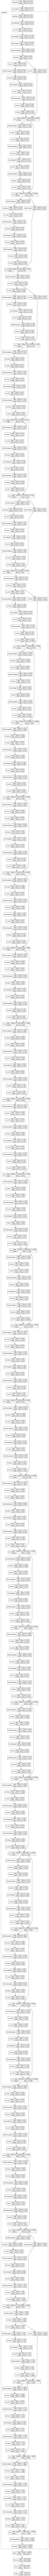

In [11]:
# Converts a Keras model to dot format and plot an image
tf.keras.utils.plot_model(best_model, show_layer_names=False, show_shapes=True, expand_nested=True, dpi=64)

#### Retrain the searched model

In [12]:
(x_train, y_train), (x_test, y_test) =  cifar10.load_data()
# scale
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshape
x_train = x_train.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)
print('Training image shape:', x_train.shape)
print('Training label shape:', y_train.shape)
print('Testing image shape:', x_test.shape)
print('Testing label shape:', y_test.shape)

# compile the model and train the model
best_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
best_model.fit(x_train, y_train, epochs=50, batch_size=64, validation_split=0.20)

Training image shape: (50000, 32, 32, 3)
Training label shape: (50000, 1)
Testing image shape: (10000, 32, 32, 3)
Testing label shape: (10000, 1)
Epoch 1/50
625/625 [==============================] - 69s 90ms/step - loss: 1.8794 - accuracy: 0.3739 - val_loss: 231.1331 - val_accuracy: 0.1378
Epoch 2/50
625/625 [==============================] - 55s 88ms/step - loss: 1.7285 - accuracy: 0.4190 - val_loss: 1.8956 - val_accuracy: 0.4644
Epoch 3/50
625/625 [==============================] - 56s 89ms/step - loss: 1.6374 - accuracy: 0.4656 - val_loss: 2.7966 - val_accuracy: 0.3301
Epoch 4/50
625/625 [==============================] - 58s 93ms/step - loss: 1.5714 - accuracy: 0.4663 - val_loss: 1.7068 - val_accuracy: 0.4262
Epoch 5/50
625/625 [==============================] - 61s 97ms/step - loss: 1.4214 - accuracy: 0.5197 - val_loss: 1.4655 - val_accuracy: 0.4709
Epoch 6/50
625/625 [==============================] - 60s 97ms/step - loss: 1.2805 - accuracy: 0.5588 - val_loss: 1.8670 - val_accur

#### Evaluate the searched model

In [13]:
# evaluate the model
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=1)
print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

313/313 [==============================] - 10s 33ms/step - loss: 1.7909 - accuracy: 0.7081
Test loss:  1.7909244298934937
Test accuracy:  0.7081000208854675


In [14]:
from tensorflow.keras.models import load_model

try:
    best_model.save("best_model_autokeras_5_2", save_format="tf")
except Exception:
    best_model.save("best_model_autokeras.h5")

D:\dl_toolkits\miniconda3\envs\akeras\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: best_model_autokeras_5_2\assets


In [15]:
loaded_model = load_model("best_model_autokeras_5_2", custom_objects=ak.CUSTOM_OBJECTS)